In [25]:
# test loading libs
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import datetime
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame
import os
import plotly.figure_factory as ff
import xarray
import cfgrib
from cfgrib import xarray_store
import h5py
import datetime as dt
from pathlib import Path

%matplotlib inline

In [26]:
import warnings
warnings.filterwarnings('ignore')

## load in  SMAP data

In [3]:
# Step 1: find all h5 files in SMAP dir
directory = "/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/"
file_num = 0
file_tracker = []
files = Path(directory).glob('*.h5')

In [4]:
for file in files:
    print(file)

/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180815_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180428_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20190118_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180530_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180219_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20171014_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170319_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20181123_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20181015_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_201

## explore an example file

In [5]:
filename = '/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20171014_R18290_001.h5'

In [6]:
# By using the command h5py.File() a filehandle is returned:
f = h5py.File(filename, 'r')
print(f)

<HDF5 file "SMAP_L3_SM_P_E_20171014_R18290_001.h5" (mode r)>


In [7]:
print("Now lets look at the groups within the file to access:")
i=0;
for key in f.keys():
    print(str(i)+ '\t'+key)
    i+=1

Now lets look at the groups within the file to access:
0	Metadata
1	Soil_Moisture_Retrieval_Data_AM
2	Soil_Moisture_Retrieval_Data_PM
3	Soil_Moisture_Retrieval_Data_Polar_AM
4	Soil_Moisture_Retrieval_Data_Polar_PM


In [8]:
group_id=list(f.keys())[1];# < Lets focus on the AM overpass for this example
i=0
print("Now lets look at the variables within the filegroup **Soil_Moisture_Retrieval_Data_AM** to access the actual data:")
for var in list(f[group_id].keys()):
    print(str(i)+'\t'+var)
    i+=1

Now lets look at the variables within the filegroup **Soil_Moisture_Retrieval_Data_AM** to access the actual data:
0	EASE_column_index
1	EASE_row_index
2	albedo
3	albedo_dca
4	albedo_scah
5	albedo_scav
6	boresight_incidence
7	bulk_density
8	clay_fraction
9	freeze_thaw_fraction
10	grid_surface_status
11	latitude
12	latitude_centroid
13	longitude
14	longitude_centroid
15	radar_water_body_fraction
16	retrieval_qual_flag
17	retrieval_qual_flag_dca
18	retrieval_qual_flag_scah
19	retrieval_qual_flag_scav
20	roughness_coefficient
21	roughness_coefficient_dca
22	roughness_coefficient_scah
23	roughness_coefficient_scav
24	soil_moisture
25	soil_moisture_dca
26	soil_moisture_error
27	soil_moisture_scah
28	soil_moisture_scav
29	static_water_body_fraction
30	surface_flag
31	surface_temperature
32	surface_water_fraction_mb_h
33	surface_water_fraction_mb_v
34	tb_3_corrected
35	tb_4_corrected
36	tb_h_corrected
37	tb_h_uncorrected
38	tb_qual_flag_3
39	tb_qual_flag_4
40	tb_qual_flag_h
41	tb_qual_flag_v


In [9]:
lat = pd.DataFrame(np.array(h5py.File(filename, 'r')['Soil_Moisture_Retrieval_Data_AM']['latitude']))

## clean an example file

### time info

In [10]:
def time_info_extractor(filename):
    filename = filename.split("SMAP_L3_SM_P_E_")[1]
    filename = filename.split(".h5")[0].split("_")[0]
    year = filename[0:4]
    month = filename[4:6]
    day = filename[6:8]
    return year, month, day
time_info_extractor(filename)

('2017', '10', '14')

### latitude info

In [11]:
def lat_info_extractor(filename, lat_min, lat_max):
    # read in the latitude into in h5 file into a dataframe
    # notice that in each row, there is only one latitude data [exception when there are invalid data [row value, -9999.0]]
    lat = pd.DataFrame(np.array(h5py.File(filename, 'r')['Soil_Moisture_Retrieval_Data_AM']['latitude']))
    # use for loop to find the valid indexs [latitude value in our area of interest]
    valid_rows = []
    latitude_value = []
    for i in range(lat.shape[0]): # loop through each row
        for lat_value in set(lat.iloc[i]): # this inner for loop counts for the case there are more than one value in each row
            if (lat_value > lat_min) and (lat_value < lat_max):
                valid_rows += [i]
                latitude_value += [lat_value]
    return valid_rows, latitude_value
            
row_index, latitude_value = lat_info_extractor(filename, 33.3, 34)  

### longitude info

In [12]:
def lon_info_extractor(filename, lon_min, lon_max):
    # read in the longitude into in h5 file into a dataframe
    # notice that in each col, there is only one latitude data [exception when there are invalid data [col value, -9999.0]]
    lon = pd.DataFrame(np.array(h5py.File(filename, 'r')['Soil_Moisture_Retrieval_Data_AM']['longitude']))
    # use the following for loop to find out col indices for our area of interest
    valid_col = []
    longitude_value = []
    for j in lon.columns: # loop through each column
        for lon_value in set(lon[j]): # this inner loop counts for appearance of invalid value
            if (lon_value > lon_min) and (lon_value < lon_max):
                valid_col += [j]
                longitude_value += [lon_value]
    return valid_col, longitude_value

col_index, longitude_value = lon_info_extractor(filename, -91, -90.2)

### soil info

In [13]:
def reset_df_index(df):
    df["row index"] = range(df.shape[0])
    df = df.set_index("row index")
    df = df.set_axis(range(df.shape[1]), axis=1, inplace=False)
    return df

In [14]:
def soil_info_extractor(filename, row_index, col_index):
    # load in the soil mositure and surface temperature dataframes
    moisture = pd.DataFrame(np.array(h5py.File(filename, 'r')['Soil_Moisture_Retrieval_Data_AM']['soil_moisture']))
    temp = pd.DataFrame(np.array(h5py.File(filename, 'r')['Soil_Moisture_Retrieval_Data_AM']['surface_temperature']))
    # only focus on the area that we care about
    moisture = moisture.iloc[row_index][col_index]
    temp = temp.iloc[row_index][col_index]
    # fix the row and column index for further changes
    moisture = reset_df_index(moisture)
    temp = reset_df_index(temp)
    # get the latitude, longitude, moisture, and temperature values
    latitude = []
    longitude = []
    moisture_value = []
    temp_value = []
    for i in moisture.index:
        for j in moisture.columns:
            latitude += [latitude_value[i]]
            longitude += [longitude_value[j]]
            moisture_value += [moisture[j][i]]
            temp_value += [temp[j][i]]
    return latitude, longitude, moisture_value, temp_value

### SMAP h5 file processor: combine functions

In [15]:
def SMAP_file_processor(filename, lat_min, lat_max, lon_min, lon_max):
    year, month, day = time_info_extractor(filename)
    row_index, latitude_value = lat_info_extractor(filename, lat_min, lat_max)
    #print(row_index, latitude_value)
    col_index, longitude_value = lon_info_extractor(filename, lon_min, lon_max)
    #print(col_index, longitude_value)
    latitude_value, longitude_value, moisture_value, temp_value = soil_info_extractor(filename, row_index, col_index)
    year_value = [year] * len(latitude_value)
    month_value = [month] * len(latitude_value)
    day_value = [day] * len(latitude_value)
    df = pd.DataFrame()
    df["year"] = year_value
    df["month"] = month_value
    df["day"] = day_value
    df["lat"] = latitude_value
    df["lon"] = longitude_value
    df["moisture"] = moisture_value
    df["temp"] = temp_value
    df = df[df['temp'] > 0]
    return df

In [16]:
filename = filename
lat_min = 18
lat_max = 54
lon_min = 73
lon_max = 135
row_index, latitude_value = lat_info_extractor(filename, lat_min, lat_max)
col_index, longitude_value = lon_info_extractor(filename, lon_min, lon_max)

In [17]:
df = SMAP_file_processor(filename, lat_min, lat_max, lon_min, lon_max)

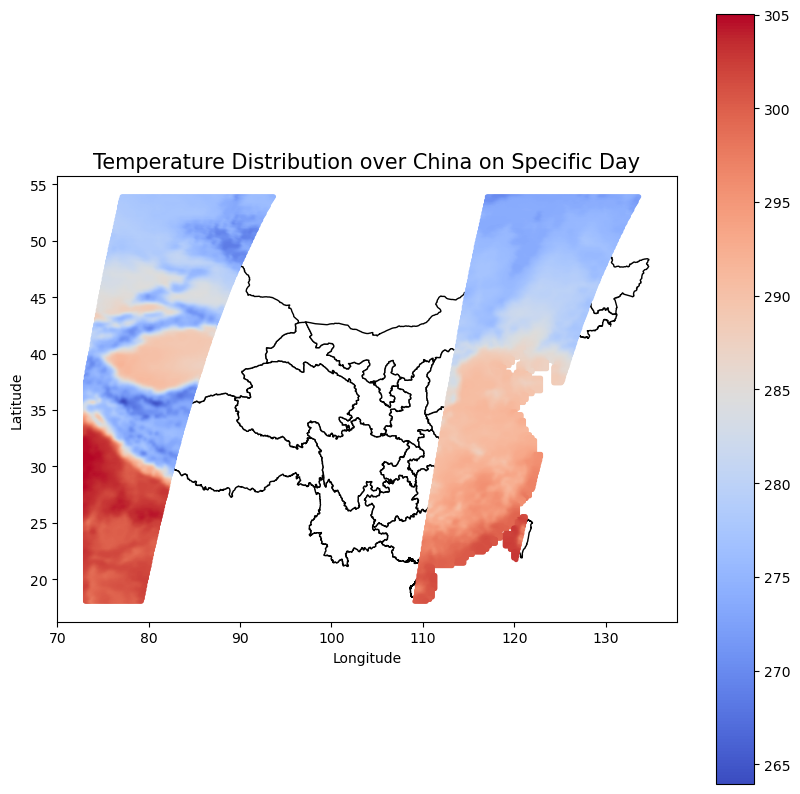

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Step 3: Convert your DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=[Point(xy) for xy in zip(df.lon, df.lat)]
)

# Set the coordinate reference system (CRS) to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Step 4: Plot the Data
# Load China's shapefile
china_shapefile = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'  # Adjust the path to your shapefile
china = gpd.read_file(china_shapefile)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
china.plot(ax=ax, color='white', edgecolor='black')

# Plot the temperature data
gdf.plot(ax=ax, column='temp', cmap='coolwarm', legend=True, markersize=5)

# Add titles and labels
ax.set_title('Temperature Distribution over China on Specific Day', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


## process the SMAP data

In [19]:
# Step 1: find all h5 files in SMAP dir
directory = "/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/"
file_num = 0
file_tracker = []
files = Path(directory).glob('*.h5')
final_df = pd.DataFrame()
for file in files:
    if "2017" in str(file):
        print(file)
        try:
            df = SMAP_file_processor(str(file), 18, 54, 73, 135)
            final_df = pd.concat([final_df, df])
        except Exception as e:
            print('Error processing file:', file, 'Error:', e)
            continue  # This

/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20171014_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170319_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170510_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170617_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170604_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170408_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170714_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170209_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170103_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_201

/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170609_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170301_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20171205_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20171028_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170508_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170818_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170708_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170521_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20171202_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_201

/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170305_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170629_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170615_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170214_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170614_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170602_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20171118_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170321_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170704_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_201

/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20171030_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20171109_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170322_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170918_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170130_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20171125_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170906_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170307_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170620_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_201

/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20171222_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170506_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20171209_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170221_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20171216_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170215_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170326_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20170723_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20171207_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_201

In [20]:
final_df.to_csv("/global/scratch/users/liuwenjin021011/data/SMAP/FactorA_Soil_Temp_Year_2017.csv", header = True, index = False)

In [21]:
# Step 1: find all h5 files in SMAP dir
directory = "/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/"
file_num = 0
file_tracker = []
files = Path(directory).glob('*.h5')
final_df = pd.DataFrame()
for file in files:
    if "2018" in str(file):
        print(file)
        try:
            df = SMAP_file_processor(str(file), 18, 54, 73, 135)
            final_df = pd.concat([final_df, df])
        except Exception as e:
            print('Error processing file:', file, 'Error:', e)
            continue  # This

/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180815_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180428_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180530_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180219_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20181123_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20181015_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180419_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20181225_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180416_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_201

/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180526_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20181130_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180204_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20181126_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180514_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180801_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180105_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20181111_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20181124_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_201

/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180730_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180615_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180922_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20181224_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180328_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180505_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180914_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20181208_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180205_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_201

/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180924_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180603_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20181209_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20181007_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180930_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180702_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180620_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180208_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180317_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_201

/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180820_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180303_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20181016_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180104_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180726_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180115_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180118_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180528_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20180407_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_201

In [22]:
final_df.to_csv("/global/scratch/users/liuwenjin021011/data/SMAP/FactorA_Soil_Temp_Year_2018.csv", header = True, index = False)

In [56]:
# Step 1: find all h5 files in SMAP dir
directory = "/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/"
file_num = 0
file_tracker = []
files = Path(directory).glob('*.h5')
final_df = pd.DataFrame()
for file in files:
    if "201906" in str(file) or '201907' in str(file):
        print(file)
        try:
            df = SMAP_file_processor(str(file), 18, 54, 73, 135)
            final_df = pd.concat([final_df, df])
        except Exception as e:
            print('Error processing file:', file, 'Error:', e)
            continue  # This

/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20190604_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20190601_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20190603_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20190607_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20190727_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20190614_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20190611_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20190606_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_20190610_R18290_001.h5
/global/scratch/users/liuwenjin021011/data/SMAP/data-processing/SMAP_L3_SM_P_E_201

In [24]:
final_df.to_csv("/global/scratch/users/liuwenjin021011/data/SMAP/FactorA_Soil_Temp_Year_2019_June_July.csv", header = True, index = False)

In [28]:
df_2017 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/SMAP/FactorA_Soil_Temp_Year_2017.csv')
df_2018 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/SMAP/FactorA_Soil_Temp_Year_2018.csv')
df_2019 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/SMAP/FactorA_Soil_Temp_Year_2019.csv')

In [41]:
df_2017

,year,month,day,lat,lon,moisture,temp
0,2017,10,14,53.8946,77.069504,0.212644,277.56760
1,2017,10,14,53.8946,77.162865,0.216615,277.55390
2,2017,10,14,53.8946,77.256226,0.202606,277.54090
3,2017,10,14,53.8946,77.349586,0.209854,277.52880
4,2017,10,14,53.8946,77.442947,0.204297,277.51807
...,...,...,...,...,...,...,...
41956719,2017,7,6,18.0480,122.256226,-9999.000000,300.84937
41956720,2017,7,6,18.0480,122.349586,-9999.000000,300.79250
41956721,2017,7,6,18.0480,122.442947,-9999.000000,300.79248
41956722,2017,7,6,18.0480,122.536308,-9999.000000,300.79250


In [51]:
df_2019[(df_2019['month'] == 3) & (df_2019['day'] == 31)]

,year,month,day,lat,lon,moisture,temp


In [ ]:
# df_2017 missing 3.30, 3.31, 4.24
# df_2018 missing 2.11, 6.27
# df_2019 missing 6.20~7.20 [Not Available on SMAP]
